# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

E:\anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Y = final['labels']

In [5]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [2]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'s', 'between', "doesn't", "you've", 'through', 'how', "you'd", "you'll", 'off', 'd', 'up', 'which', 'until', 'by', "it's", 'on', 'weren', "needn't", 'no', "should've", 'all', 'ma', 'if', 'shan', 'is', 'further', 've', "don't", "hasn't", 'theirs', 'they', 'that', "isn't", 'only', 'them', 'where', 'himself', 'in', 'doesn', 'll', 'will', 'some', 'was', 'having', "shouldn't", 'your', "weren't", 'been', 'did', 'at', 'aren', 'very', 'ourselves', 'yours', 'own', 'the', 'any', 'does', 'out', 'from', 'because', 'yourself', 'didn', 'just', 'have', 'than', 'their', "that'll", 'being', 'what', 'she', 'were', 'wasn', 'i', "wouldn't", 'here', 'an', 'hasn', 'yourselves', 'above', 'below', 'are', 'you', 'myself', 'about', "you're", 'he', 'itself', 'why', 'of', 'before', 'mustn', 'who', 'herself', 'him', 'not', 'hers', 'during', 'over', 'with', 'my', 'other', 'couldn', 'me', 'whom', 'had', "haven't", "won't", 'but', 'be', 'once', 'wouldn', 'such', "didn't", 'has', "couldn't", 'a', 'm', 'themselves', 

In [26]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [27]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [13]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

## Separating data into Train ,Cross-validation,Test

In [3]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query('SELECT * FROM Reviews',con)

from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
def values(x):
    if x == 'positive':
        return 1
    return 0
X = final['Text'].values
label = final['Score']
Y = label.map(values)

## Test data split ##
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)
 


In [12]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
def values(x):
    if x == 'positive':
        return 1
    return 0
X = final['Text'].values
label = final['Score']
Y = label.map(values)

## Test data split ##
X_1, X_test, Y_1, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_cv, Y_train, Y_cv = cross_validation.train_test_split(X_1, Y_1, test_size=0.3, random_state=0)

# [7.2.2] Bag of Words (BoW)

In [17]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_train)
X_final = count_vect.transform(X_test)

## Knn On Bow


The best value of K:  9.


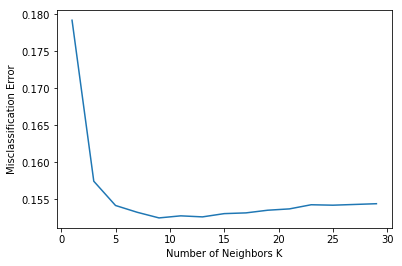

In [11]:
############   Using 10-fold cross validation ###############################
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, final_counts[0:50000], Y_train[0:50000], cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


The best value of K:  5.


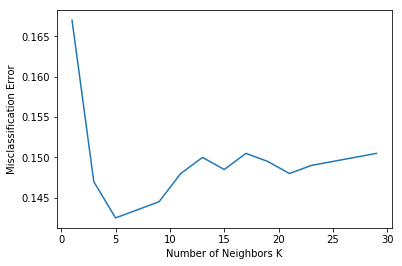

In [17]:
########################     Using dedicated data for cross validation  ########################
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(final_counts[0:50000],Y_train[0:50000])
    pred = knn.predict(X_final[0:2000])
    score = accuracy_score(Y_cv[0:2000],pred)
    cv_scores.append(score)
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [72]:
knn=KNeighborsClassifier(n_neighbors=9)
knn.fit(final_counts[0:50000,:],Y_train[0:50000])
predicted=knn.predict(final_counts[0:3000])
result = accuracy_score(Y_train[0:3000],predicted,normalize=True)*float(100)
print("Accuracy on training set is: ",result)

Accuracy on training set is:  84.66666666666667


In [15]:
import time
b = time.time()
X_final = count_vect.transform(X_test)
knn=KNeighborsClassifier(n_neighbors=9,algorithm='brute')
knn.fit(final_counts[0:30000,:],Y_train[0:30000])
predicted=knn.predict(X_final[0:3000,:])
result = accuracy_score(Y_test[0:3000],predicted,normalize=True)*float(100)
print("Accuracy on test set is: ",result)
a = time.time()
print('time taken using brute force: {:.2f} '.format(1000*(a-b)),'millisecond')

Accuracy on test set is:  85.23333333333333
time taken using brute force: 22651.11  millisecond


In [19]:
from sklearn.metrics import confusion_matrix
import time
b = time.time()
knn=KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(final_counts[0:30000,:],Y_train[0:30000])
predicted=knn.predict(X_final[0:3000,:])
result = accuracy_score(Y_test[0:3000],predicted,normalize=True)*float(100)
con = confusion_matrix(Y_test[0:3000],predicted)
print("Accuracy on test set is: ",result)
print('confusion matrix')
print(con)
a = time.time()
print('time taken using kdtree: {:.2f} '.format(1000*(a-b)),'millisecond')

E:\anaconda\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Accuracy on test set is:  85.23333333333333
confusion matrix
[[  18  429]
 [  14 2539]]
time taken using kdtree: 11568.73  millisecond


## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [ ]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [4]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(X_train)
X_cv_grams = count_vect.transform(X_test)

In [16]:
final_bigram_counts.get_shape()

(178443, 1857301)

## KNN on n_grams


The best value of K:  9.


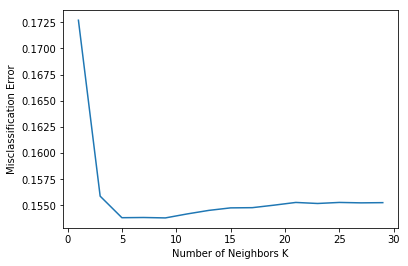

In [13]:
#####################             Using 10-fold cross validation #########################
cv_scores=[]
k_grams=[]
j=0
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, final_bigram_counts[0:50000], Y_train[0:50000], cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    k_grams.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k_grams[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k_grams,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


The best value of K:  3.


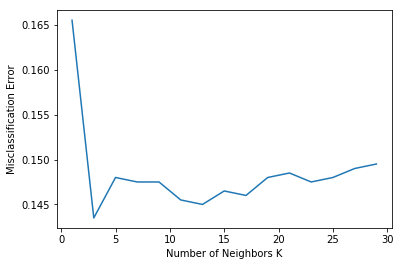

In [19]:
#########################   Using dedicated cross validation ######################
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(final_bigram_counts[0:50000],Y_train[0:50000])
    pred = knn.predict(X_cv_grams[0:2000])
    score = accuracy_score(Y_cv[0:2000],pred)
    cv_scores.append(score)
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [10]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='brute')
knn.fit(final_bigram_counts[0:40000],Y_train[0:40000])
predict=knn.predict(final_bigram_counts[0:7000,:])
result = accuracy_score(Y_train[0:7000],predict,normalize=True)*float(100)
print('Accuracy on training dataset: ',result)

Accuracy on training dataset:  84.57142857142857


In [9]:
import time
from sklearn.metrics import confusion_matrix
b= time.time()
X_test_grams = count_vect.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=9,algorithm='brute')
knn.fit(final_bigram_counts[0:20000],Y_train[0:20000])
predict=knn.predict(X_test_grams[0:7000,:])
result = accuracy_score(Y_test[0:7000],predict,normalize=True)*float(100)
con = confusion_matrix(Y_test[0:7000],predict)
print("Accuracy on test set is: ",result)
print('confusion matrix')
print(con)
a=time.time()
print('time taken using brute force: {:.2f}'.format(1000*(a-b)),"millisecond")

Accuracy on test set is:  84.87142857142858
confusion matrix
[[  41 1039]
 [  20 5900]]
time taken using brute force: 42843.21 millisecond


In [20]:
b= time.time()
X_test_grams = count_vect.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(final_bigram_counts[0:40000],Y_train[0:40000])
predict=knn.predict(X_test_grams[0:7000,:])
result = accuracy_score(Y_test[0:7000],predict,normalize=True)*float(100)
print('Accuracy on test dataset: ',result)
a=time.time()
print('time taken using kdtree: {:.2f}'.format(1000*(a-b)),"millisecond")

E:\anaconda\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Accuracy on test dataset:  84.85714285714285
time taken using kdtree: 62379.13 millisecond


# [7.2.5] TF-IDF

In [27]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

In [48]:
final_tf_idf[0]

<1x2334136 sparse matrix of type '<class 'numpy.float64'>'
	with 172 stored elements in Compressed Sparse Row format>

In [31]:
final_tf_idf.get_shape()


(178443, 1856450)

## Knn on TF_IDF


The best value of K:  9.


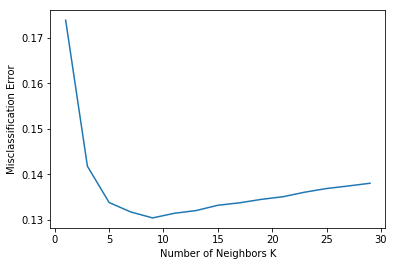

In [16]:
cv_scores=[]
k_tfidf=[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, final_tf_idf[0:50000], Y_train[0:50000], cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    k_tfidf.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k_tfidf[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k_tfidf,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


The best value of K:  3.


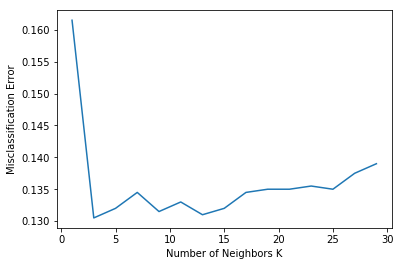

In [22]:
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(final_tf_idf[0:50000],Y_train[0:50000])
    pred = knn.predict(X_cv_tfidf[0:2000])
    score = accuracy_score(Y_cv[0:2000],pred)
    cv_scores.append(score)
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [12]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(final_tf_idf[0:20000],Y_train[0:20000])
pred = knn.predict(final_tf_idf[0:7000])
acc = accuracy_score(Y_train[0:7000], pred, normalize=True) * float(100)
print('accuracy on training data',acc)

E:\anaconda\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


accuracy on training data 87.75714285714285


In [29]:
b = time.time()
knn = KNeighborsClassifier(n_neighbors=9,algorithm='brute')
knn.fit(final_tf_idf[0:20000],Y_train[0:20000])
pred = knn.predict(X_test_tfidf[0:7000])
acc = accuracy_score(Y_test[0:7000], pred, normalize=True) * float(100)
con = confusion_matrix(Y_test[0:7000],pred)
print("Accuracy on test set is: ",result)
print('confusion matrix')
print(con)
a = time.time()
print ("time taken using brute: {:.2f}".format(1000*(a-b)),'millisec')

Accuracy on test set is:  84.87142857142858
confusion matrix
[[ 173  907]
 [  30 5890]]
time taken using brute: 16419.67 millisec


In [24]:
b = time.time()
knn = KNeighborsClassifier(n_neighbors=9,algorithm='kd_tree')
knn.fit(final_tf_idf[0:20000],Y_train[0:20000])
pred = knn.predict(X_test_tfidf[0:7000])
acc = accuracy_score(Y_test[0:7000], pred, normalize=True) * float(100)
print('accuracy',acc)
a = time.time()
print ("time taken using kdtree: {:.2f}".format(1000*(a-b)),'millisec')

E:\anaconda\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


accuracy 86.61428571428571
time taken using kdtree: 16405.03 millisec


In [ ]:
features = tf_idf_vect.get_feature_names()
len(features)


In [ ]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [ ]:
top_tfidf


# [7.2.6] Word2Vec

In [ ]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)



In [4]:
import gensim
i=0
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

E:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
i =0
list_of_Xtest =[]
for sent in X_test:
    filtered_Xtest = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_Xtest.append(cleaned_words.lower())
            else:
                continue
    list_of_Xtest.append(filtered_Xtest)

In [5]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    


In [7]:
w2v_model.wv.most_similar('woman')

[('neighbor', 0.7500136494636536),
 ('maniac', 0.7391310930252075),
 ('man', 0.7344357967376709),
 ('coworker', 0.7280142307281494),
 ('grandfather', 0.7086580395698547),
 ('teen', 0.7077393531799316),
 ('gentleman', 0.7075867652893066),
 ('lady', 0.7051108479499817),
 ('hiker', 0.7023972868919373),
 ('freshman', 0.701340913772583)]

In [8]:
w2v_model.wv.similarity('woman', 'man')

0.7344358293284958

# [7.2.7] Avg W2V, TFIDF-W2V

In [31]:

sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

E:\anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


254919
50



The best value of K:  11.


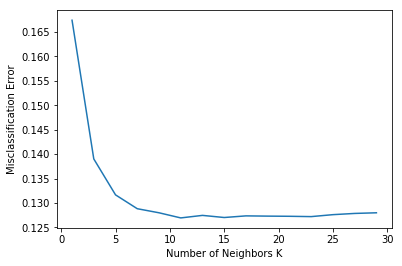

In [24]:
###########             using 10-fold cross validation ############
cv_scores_avgw2vec =[]
k_avgw2vec = []
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, sent_vectors[0:60000], Y_train[0:60000], cv=10, scoring='accuracy')
    cv_scores_avgw2vec.append(scores.mean())
    k_avgw2vec.append(i)
MSE = [1-x for x in cv_scores_avgw2vec]
optimal_k = k_avgw2vec[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k_avgw2vec,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


The best value of K:  17.


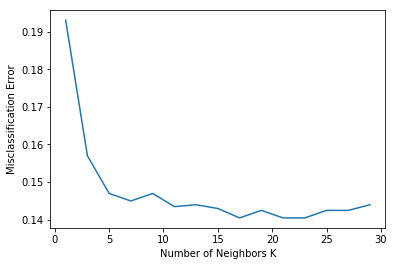

In [50]:
#################           Using dedicated cross validation set            #############################
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(sent_vectors[0:60000],Y_train[0:60000])
    pred = knn.predict(sent_vectors_xtest[0:2000])
    score = accuracy_score(Y_cv[0:2000],pred)
    cv_scores.append(score)
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [32]:
sent_vectors_xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_Xtest: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_xtest.append(sent_vec)

In [60]:
knn=KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')
knn.fit(sent_vectors[0:60000],Y_train[0:60000])
predicted=knn.predict(sent_vectors[0:60000])
result = accuracy_score(Y_train[0:60000],predicted,normalize=True)*float(100)
print("Accuracy on test set is: ",result)

Accuracy on test set is:  88.79


In [32]:
b = time.time()
knn=KNeighborsClassifier(n_neighbors=11,algorithm='brute')
knn.fit(sent_vectors[0:60000],Y_train[0:60000])
predicted=knn.predict(sent_vectors_xtest[0:3000])
result = accuracy_score(Y_test[0:3000],predicted,normalize=True)*float(100)
con = confusion_matrix(Y_test[0:3000],predicted)
print('accuracy on test data: ',result*100,"%")
print('confusion matrix')
print(con)
a = time.time()
print ("time taken using brute force: {:.2f}".format(1000*(a-b)),'millisec')

accuracy on test data:  8476.666666666666 %
confusion matrix
[[   2  445]
 [  12 2541]]
time taken using brute force: 3813.64 millisec


In [59]:
b = time.time()
knn=KNeighborsClassifier(n_neighbors=11,algorithm='kd_tree')
knn.fit(sent_vectors[0:60000],Y_train[0:60000])
predicted=knn.predict(sent_vectors_xtest[0:3000])
result = accuracy_score(Y_test[0:3000],predicted,normalize=True)*float(100)
print("Accuracy on test set is: ",result)
a = time.time()
print ("time taken using kd_tree: {:.2f}".format(1000*(a-b)),'millisec')

Accuracy on test set is:  87.7
time taken using kd_tree: 51758.42 millisec


## KNN on Tf-IDF Word2vec

In [33]:
# TF-IDF weighted Word2Vec

tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent[0:1000]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

    

In [34]:
test_tfidf = tf_idf_vect.fit_transform(X_test)

In [35]:
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_xtest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_Xtest[0:100]: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = test_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_xtest.append(sent_vec)
    row += 1
    


The best value of K:  7.


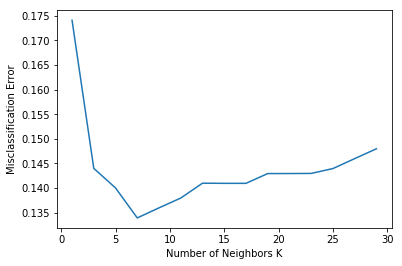

In [20]:
######################      Using 10-fold cross validation    ####################
cv_scores_w2vec_tfidf =[]
k_w2vec_tfidf =[]
for i in range(1,31,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, tfidf_sent_vectors[0:1000], Y_train[0:1000], cv=10, scoring='accuracy')
    cv_scores_w2vec_tfidf.append(scores.mean())
    k_w2vec_tfidf.append(i)
     
MSE = [1-x for x in cv_scores_w2vec_tfidf]
optimal_k = k_w2vec_tfidf[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k_w2vec_tfidf,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


The best value of K:  13.


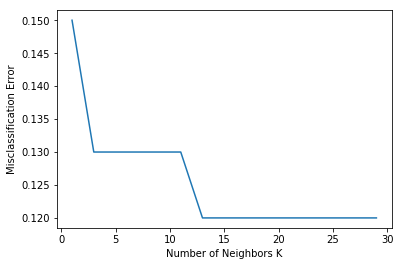

In [62]:
#################           Using dedicated cross validation set            #############################
cv_scores=[]
k =[]
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(tfidf_sent_vectors[0:1000], Y_train[0:1000])
    pred = knn.predict(tfidf_sent_vectors_xtest[0:100])
    score = accuracy_score(Y_cv[0:100],pred)
    cv_scores.append(score)
    k.append(i)
MSE = [1-x for x in cv_scores]
optimal_k = k[MSE.index(min(MSE))]
print('\nThe best value of K:  %d.' % optimal_k)
plt.plot(k,MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [60]:
b = time.time()
knn=KNeighborsClassifier(n_neighbors=7,algorithm='brute')
knn.fit(tfidf_sent_vectors[0:1000], Y_train[0:1000])
predicted=knn.predict(tfidf_sent_vectors_xtest[0:100])
result = accuracy_score(Y_test[0:100],predicted,normalize=True)*float(100)
print("Accuracy on test set is: ",result)
a = time.time()
print ("time taken using brute: {:.2f}".format(1000*(a-b)),'millisec')

Accuracy on test set is:  84.0
time taken using brute: 41.00 millisec


In [35]:
b = time.time()
knn=KNeighborsClassifier(n_neighbors=7,algorithm='kd_tree')
knn.fit(tfidf_sent_vectors[0:1000], Y_train[0:1000])
predicted=knn.predict(tfidf_sent_vectors_xtest[0:100])
result = accuracy_score(Y_test[0:100],predicted,normalize=True)*float(100)
con = confusion_matrix(Y_test[0:100],predicted)
print('accuracy on test data: ',result*100,"%")
print('confusion matrix')
print(con)
a = time.time()
print ("time taken using kd_tree: {:.2f}".format(1000*(a-b)),'millisec')

accuracy on test data:  8100.0 %
confusion matrix
[[ 0 15]
 [ 4 81]]
time taken using kd_tree: 537.22 millisec


In [59]:

knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(tfidf_sent_vectors[0:1000], Y_train[0:1000])
predicted=knn.predict(tfidf_sent_vectors[0:1000])
result = accuracy_score(Y_train[0:1000],predicted,normalize=True)*float(100)
print("Accuracy on traning set is: ",result)

Accuracy on traning set is:  88.0


## Conclusion and summary

Following step wise approach is used for each type of vectorizer and embeddings 
- Converting the review into proper vectorized form or embeddings
- Finding the right K using 10-fold cross validation
- Finding the right K using dedicated cross validation data
- applying Knn on test data using brute force algorithm and calculating performance
- applying knn on test data using kd_tree algorithm and calculating performance
- getting performance over training data

#### performance table for training data

|   Algorithms     | Bow  | Bigrams  | tf_idf  | avgword2vec  | tfidf_word2vec  |
|------------------|------|----------|---------|--------------|-----------------|
| K using 10-folds | 9    |    9     |    9    |     11       |       7         |
|------------------|------|----------|---------|--------------|-----------------|
| K using cv       | 5    |    3     |    3    |     17       |       13        |
|------------------|------|----------|---------|--------------|-----------------|
|   accuracy       | 85   |    85    |  87.5   |    88.79     |      88         |

#### Performace on test data

|   Algorithms                          | Bow       | Bigrams  | tf_idf  | avgword2vec   | tfidf_word2vec  |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|
| K using 10-folds                      | 9         |    9     |    9    |     11        |       7         |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|
| K using cv                            | 5         |    3     |    3    |     17        |       13        |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|
|   accuracy                            | 85        |   84.85  |  86.61  |     87.1      |      84.0       |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|
|time taken using kd_tree(millisec)     |22335.08-  | 62379.13 | 16405.03|    51758.42   |       30        |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|
|time taken using brute force(millisec) |22651.11   | 62549.64 | 16990.05|   6572.74     |       41        |
|---------------------------------------|-----------|----------|---------|---------------|-----------------|


### Confusion matrix

#### Bow

| 18 |429 |
|----|----|
| 14 |2539|

#### Bigrams

| 41  |1039|
|-----|----|
|  20 |5900|

#### tf_idf

| 173| 907|
|----|----|
| 30 |5890|

#### Avg word2vec

| 2     | 445   |
|-------|-------|
|  12   | 2541  |

#### tf_idf weighted word2vec

|   0    |   15   |
|--------|--------|
|   4    |  81    |